# Workbook for Callbacks

Workbook for all the callbacks we write for Learning Rate Scheduling

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import tensorflow as tf

from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model, load_model

from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

import os
#import seaborn as sns
plt.style.use('ggplot')

print(tf. __version__) 

# suppress tensorflow warnings and error messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

2.2.0


In [2]:
# params
n_layers = 2
n_neurons = 100

In [3]:
(x_train,y_train),(x_test,y_test) = fashion_mnist.load_data()

print('loaded fashion mnist data')

print(f'train_shape: {x_train.shape, y_train.shape}')
print(f'test shape: {x_test.shape, y_test.shape}')

img_shape = x_train[0].shape
n_classes = len(np.unique(y_train))

print(f'{img_shape} images in {n_classes} classes')

loaded fashion mnist data
train_shape: ((60000, 28, 28), (60000,))
test shape: ((10000, 28, 28), (10000,))
(28, 28) images in 10 classes


In [4]:
x_train = x_train.astype('float32')/255.
x_test = x_test.astype('float32')/255.
x_val, y_val = x_train[:10000],y_train[:10000]
x_train, y_train = x_train[10000:],y_train[10000:]

print(f'train_shape: {x_train.shape, y_train.shape}')
print(f'val shape: {x_val.shape, y_val.shape}')

train_shape: ((50000, 28, 28), (50000,))
val shape: ((10000, 28, 28), (10000,))


In [5]:
def dnn_layer(x,n_neurons,activation,initializer,batch_norm=False):
    x = Dense(n_neurons,activation=activation,kernel_initializer=initializer)(x)
    if batch_norm:
        x = BatchNormalization()(x)
    return x

def build_dnn(data_shape,n_classes,n_neurons,n_layers,
              activations,initializer,batch_norm=False):
    inputs = Input(data_shape)
    x = Flatten(input_shape=data_shape)(inputs)
    for _ in range(n_layers):
        x = dnn_layer(x,n_neurons,activation,initializer,batch_norm)
    outputs = Dense(n_classes,activation='softmax')(x)
    dnn = Model(inputs,outputs)
    return dnn

In [6]:
activation = 'elu'
initializer = 'he_normal'

In [7]:
K = tf.keras.backend

class UpdateLrMB(tf.keras.callbacks.Callback):
    def __init__(self,factor,beta=0.98,tolerance = 4,plot_automatic=True,plot_unsmoothed=True):
        self.factor = factor # factor to multiply LR with after every minibatch
        self.beta = beta # 
        self.learning_rate = [] # record lr at every minibatch
        self.loss = [] # loss recorded by TF at end of minibatch. for TF >= 2.2, this is a running average from the beginning of the epoch 
        self.avg_loss = [] # exponentially weighted average of loss
        self.min_loss = np.Inf
        self.current_avg_loss = 0 # at the beginning of training
        self.tolerance = tolerance # the loss can increase to up to tolerance*min_loss
        self.plot_automatic = plot_automatic
        self.plot_unsmoothed = plot_unsmoothed
        self.iteration = 0
    
    def on_train_begin(self,epoch):
        self.current_avg_loss = 0
        self.iteration = 0
    
    def on_batch_end(self,batch,logs): # at the end of first batch, batch=0
        self.iteration += 1
        current_lr = K.get_value(self.model.optimizer.learning_rate)
        current_loss = logs['loss']
        self.current_avg_loss = (self.beta*self.current_avg_loss+(1-self.beta)*current_loss)
        smooth_avg_loss = self.current_avg_loss/(1-self.beta**(self.iteration+1))
        self.min_loss = min(self.min_loss,smooth_avg_loss)
        self.learning_rate.append(current_lr)
        self.loss.append(current_loss)
        self.avg_loss.append(smooth_avg_loss)
        K.set_value(self.model.optimizer.learning_rate,current_lr*self.factor)
        if current_loss >= (self.tolerance * self.min_loss): # stop scanning if exponentially weighted average grows too high
            self.model.stop_training = True
            return
    
    def on_train_end(self,epoch):
        if self.plot_automatic:
            self.plot_lr_vs_loss()
    
    def plot_lr_vs_loss(self,clipstart=10,clipend=1):
        clip = lambda x : x[clipstart:-clipend]
        lr = clip(self.learning_rate)
        avg_loss = clip(self.avg_loss)
        loss = clip(self.loss)
        plt.plot(lr,avg_loss,label='exponentially weighted loss')
        if self.plot_unsmoothed:
            plt.plot(lr,loss,alpha=0.4,label='unsmoothed')
        plt.gca().set_xscale('log')
        minrate = min(self.learning_rate)
        maxrate = max(self.learning_rate)
        minloss = min(self.loss)
        maxloss = self.loss[0]+0.5
        plt.axis([minrate,maxrate,minloss,maxloss])
        plt.xlabel("Learning rate")
        plt.ylabel("Loss")
        plt.legend(loc='best')
        plt.show()
        
def scan_learning_rate(model,X,y,epochs=1,batch_size=32,minrate=1e-10,maxrate=1):
    model_weights = model.get_weights() # save weights before the learning rate scan
    iterations = np.ceil(len(X)/batch_size)*epochs
    lr_factor = np.exp(np.log(maxrate/minrate)/iterations)
    K.set_value(model.optimizer.learning_rate,minrate)
    lr_update = UpdateLrMB(lr_factor)
    model.fit(X,y,epochs=epochs,batch_size=batch_size,callbacks=[lr_update])
    model.set_weights(model_weights) # restore weights
    return lr_update

model compiled
Epoch 1/2
1563/1563 [==============================] - 3s 2ms/step - loss: 2.4768
Epoch 2/2
1563/1563 [==============================] - 3s 2ms/step - loss: 222.7836


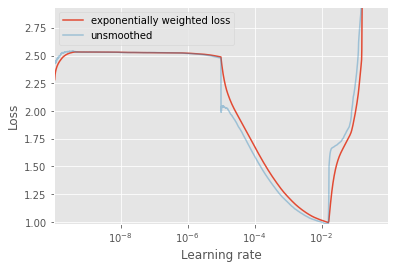

In [8]:
optimizer = tf.keras.optimizers.Nadam()
model = build_dnn(img_shape,n_classes, n_neurons, 
                  n_layers, activation, initializer,
                  batch_norm=False)

model.compile(loss='sparse_categorical_crossentropy',optimizer=optimizer)
print('model compiled')

lr_logs= scan_learning_rate(model,x_train,y_train,epochs=2)

In [9]:
class OneCycle(tf.keras.callbacks.Callback):
    def __init__(self,n_train,batch_size,n_epochs,lr_max,lr_start=None,lr_end=None):
        self.n_train = n_train
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.lr_max = lr_max 
        self.lr_start = lr_start or lr_max/10
        self.lr_end = lr_end or lr_max/1000
        self.num_iter = np.ceil(n_train/batch_size) *n_epochs #total number of iterations
        self.last_iterations = self.num_iter//10 +1 #about last 10 percent of the training iterations
        self.iter_cycle = self.num_iter-self.last_iterations
        self.iter_midpt = self.iter_cycle//2
        self.iteration = 0
        self.current_lr = self.lr_start
        self.lr_record = []
    
    def on_batch_begin(self,epoch,logs):
        lr = self._learning_rate(self.iteration)
        self.iteration += 1
        self.current_lr = lr
        self.lr_record.append(lr)
        K.set_value(self.model.optimizer.learning_rate,lr)
        
    def on_epoch_begin(self,epoch,logs):
        print('learning rate approximately: {:.1e}'.format(self.current_lr))
        
    def _linear_learning_rate(self,x,
                              startx,stopx,
                              starty,stopy):
        return ((stopy-starty)*(x-startx)/(stopx-startx))+starty
    
    def _learning_rate(self,iteration):
        if iteration < self.iter_midpt:
            lr = self._linear_learning_rate(iteration,
                                            0,self.iter_midpt,
                                            self.lr_start,self.lr_max)
        elif iteration < self.iter_cycle:
            lr = self._linear_learning_rate(iteration,
                                            self.iter_midpt,self.iter_cycle,
                                            self.lr_max,self.lr_start)
        else:
            lr = self._linear_learning_rate(iteration,
                                            self.iter_cycle,self.num_iter,
                                            self.lr_start,self.lr_end)
        return lr
    
    def get_lr_record(self):
        return self.lr_record

In [10]:
lr_optimal = 1e-3
lr_start = lr_optimal/10

optimizer = tf.keras.optimizers.Nadam(learning_rate=lr_optimal)
model = build_dnn(img_shape,n_classes, n_neurons, 
                  n_layers, activation, initializer,
                  batch_norm=False)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,metrics=['accuracy'])
print('model compiled')

model compiled


In [11]:
#TODO : because we pass n_train into the LR scheduler we can't use validation_split in model.fit() 
#and have to explicitly give validation data separately. Fix this.

n_train = len(x_train) 
n_epochs = 20
batch_size = 32

lr_scheduler = OneCycle(n_train,
                        batch_size=batch_size,
                        n_epochs=n_epochs,
                        lr_max=lr_optimal,lr_end=1e-6)

callbacks = [lr_scheduler]

In [13]:
history = model.fit(x_train,y_train,validation_data = (x_val,y_val),
                    epochs=n_epochs,batch_size = batch_size,callbacks=callbacks)

learning rate approximately: 1.0e-04
Epoch 1/20
1563/1563 [==============================] - 3s 2ms/step - loss: 0.6483 - accuracy: 0.7799 - val_loss: 0.4811 - val_accuracy: 0.8250
learning rate approximately: 2.0e-04
Epoch 2/20
1563/1563 [==============================] - 3s 2ms/step - loss: 0.4309 - accuracy: 0.8483 - val_loss: 0.4072 - val_accuracy: 0.8520
learning rate approximately: 3.0e-04
Epoch 3/20
1563/1563 [==============================] - 3s 2ms/step - loss: 0.3870 - accuracy: 0.8607 - val_loss: 0.3752 - val_accuracy: 0.8663
learning rate approximately: 4.0e-04
Epoch 4/20
1563/1563 [==============================] - 3s 2ms/step - loss: 0.3594 - accuracy: 0.8703 - val_loss: 0.3691 - val_accuracy: 0.8674
learning rate approximately: 5.0e-04
Epoch 5/20
1563/1563 [==============================] - 3s 2ms/step - loss: 0.3384 - accuracy: 0.8761 - val_loss: 0.3516 - val_accuracy: 0.8701
learning rate approximately: 6.0e-04
Epoch 6/20
1563/1563 [==============================] - 3s

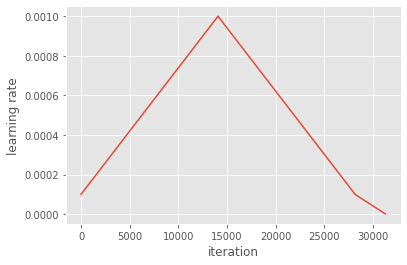

In [14]:
plt.plot(lr_scheduler.get_lr_record())
plt.xlabel('iteration')
plt.ylabel('learning rate')
plt.show()

In [19]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

313/313 [==============================] - 0s 719us/step - loss: 0.3188 - accuracy: 0.8948
Test loss: 0.31880778074264526
Test accuracy: 0.8948000073432922
